# Imports

In [53]:
import jieba
from jieba import posseg as pseg

import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
from math import exp
import seaborn as sns
sns.set_theme()

df = pd.read_excel("CAC.xlsx")

print(len(df))

# filter to the documents that have been issued after public comments
df_comments = df.loc[df["status"] == "doc issued after public comments"].reset_index(drop=True)
print(len(df_comments))

# filter out policy documents
df_comments = df_comments.loc[df_comments["data_category"] == "reg"].reset_index(drop=True)
print(len(df_comments))


58
25
25


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
from matplotlib import rcParams

# Global grayscale academic style
rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'grid.linestyle': ':',
    'grid.color': 'gray',
    'grid.alpha': 0.5,
    'figure.dpi': 300
})

bg_color="#ffffff"

# Similarity functions

These functions generate the similarity metrics, using Jaccard and cosine similarity.

In [55]:
js = []
cs = []
ed = []

def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union

def get_cosine_similarity(documents):
    
    def clean_text(text):
        """
        cleans text, removes basic stopwords
        
        
        """
        jieba_stop_words = ['的', '了', '和', '是', '就', '都', '而', '及', '与', 
                            '者', '或', '一个', '没有', '我们', '你们', '是否']
        sentence = [re.sub ("\/", "_", str (item)) for item in pseg.cut(text)] 
        sentence = [word for word in sentence if not re.search ("_ns|_x|_m", word)] #exclude place names, non-morphemes, measures 
        sentence = [word for word in sentence if not word in jieba_stop_words]
        #sentence = [word for word in sentence if len (re.sub ("_.*", "", word))>1] #restrict to two-character words
        #sentence = [word for word in sentence if re.search ("_n|_v|_j", word)] #restrict to nouns, verbs, adjectives,  
        return ' '.join(list(re.sub ("_.*", "", word) for word in sentence))
    new_docs = []
    
    for doc in documents:
        new_docs.append(clean_text(doc))
        
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform(new_docs)
    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(
       doc_term_matrix,
       columns=count_vectorizer.get_feature_names_out(),
       index=["full", "draft"],
    )
    #print(df)
    cs = cosine_similarity(df, df)[0][1]
    
    
    #cs = cs[0].astype(int)
    return cs

# Execute functions

In [56]:
for i in range(len(df_comments)):
    t = str(df_comments["text_final"][i])
    t = re.sub("[^\u4e00-\u9FFF\d]", "", t)
    fulltext_split = " ".join(jieba.cut(t, use_paddle=True))
    f_s = set(fulltext_split.split(" "))
    #print(fulltext_split)
    
    d = str(df_comments["text_draft"][i])
    d = re.sub("[^\u4e00-\u9FFF\d]", "", d)
    draft_split = " ".join(jieba.cut(d, use_paddle=True))
    d_s = set(draft_split.split(" "))
    
    
    s = jaccard_similarity(f_s, d_s)
    documents = [fulltext_split, draft_split]
    c = get_cosine_similarity(documents)
    
    js.append(s)
    cs.append(c)
    
    
df_comments["jaccard_similarity"] = js
df_comments["cosine_similarity"] = cs

df_comments = df_comments.loc[df_comments["cosine_similarity"] > 0].reset_index(drop=True)
df_comments.to_excel("CAC_Analysis.xlsx")


# Analysis

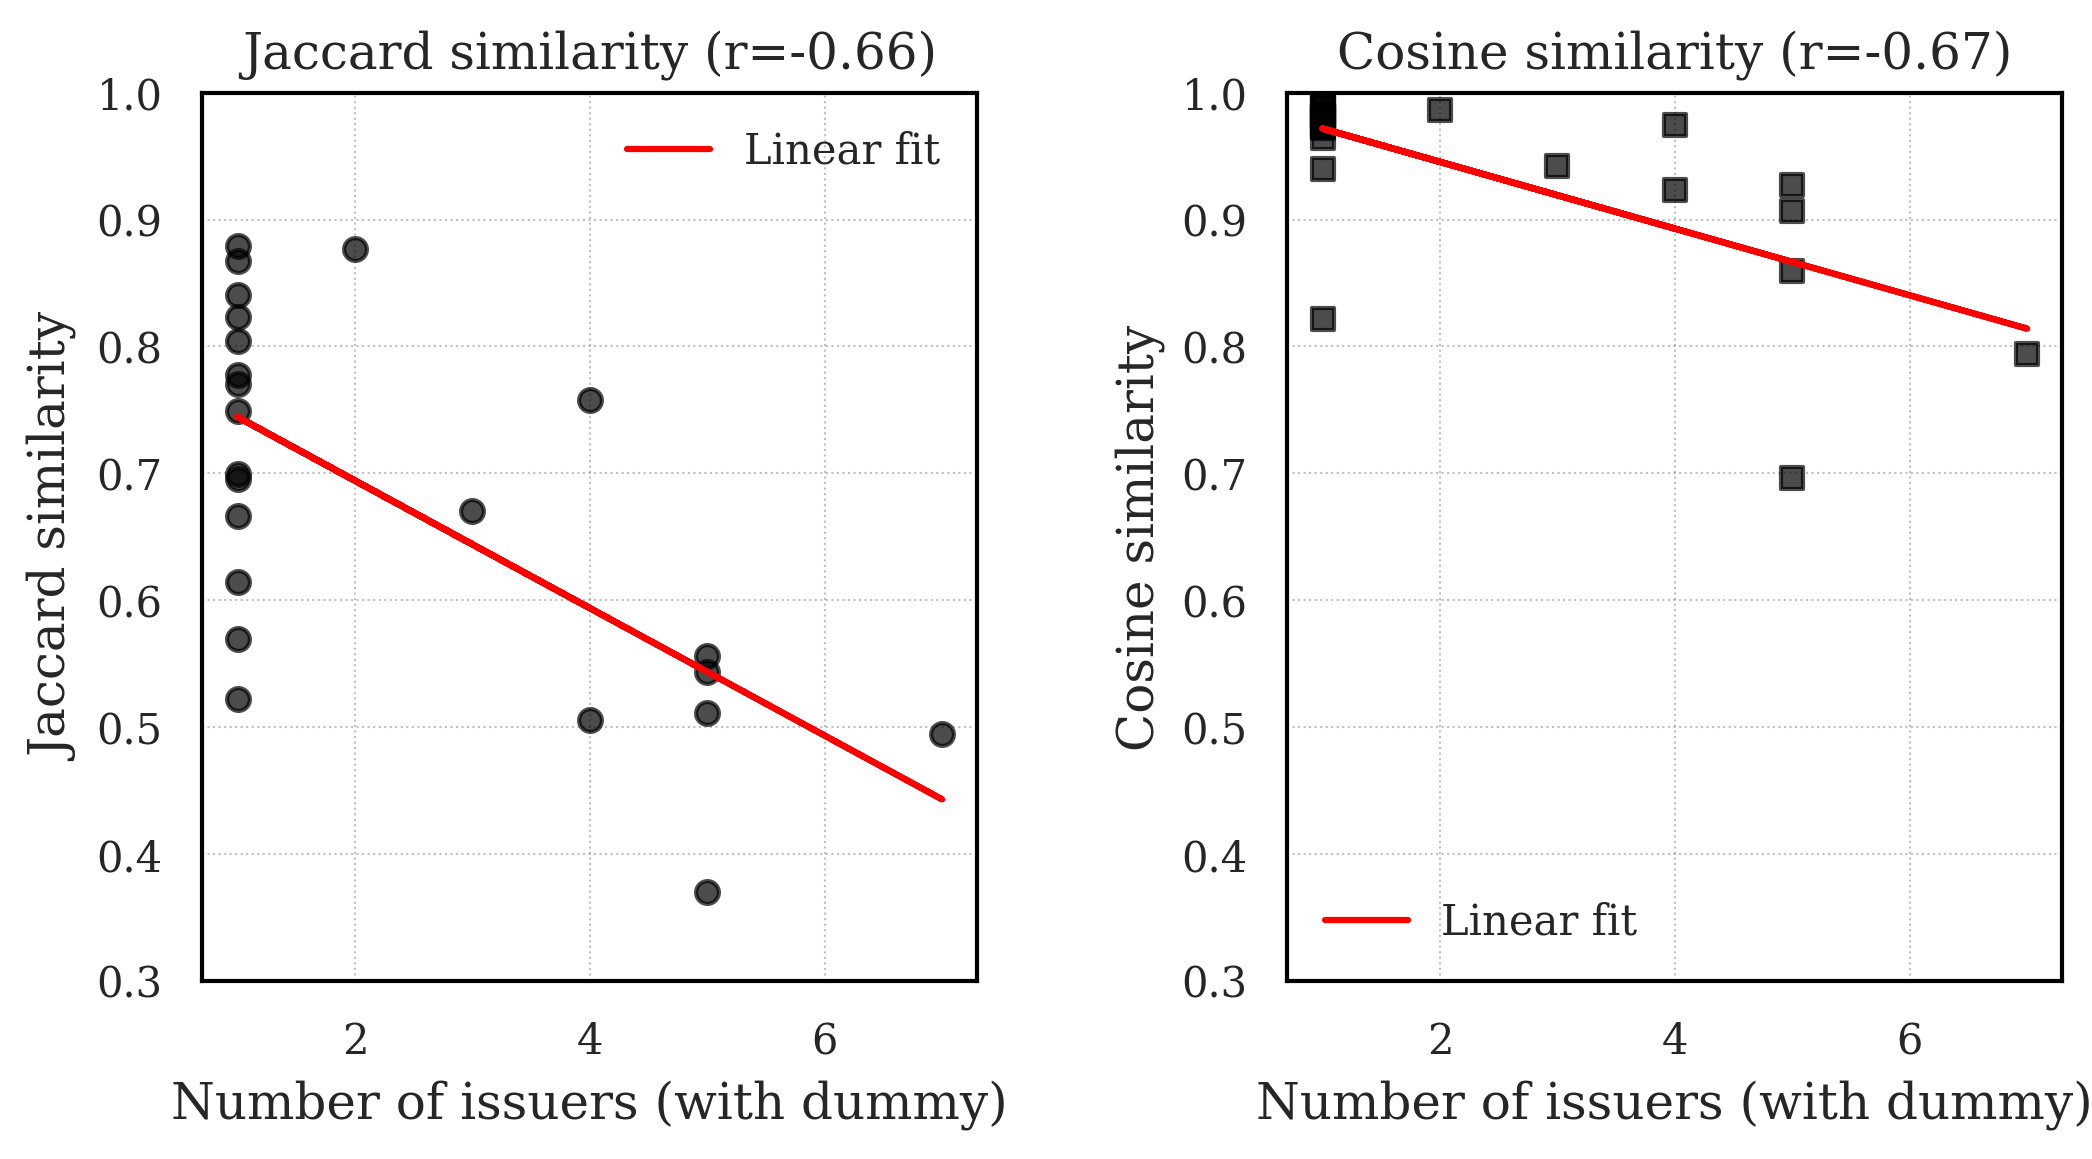

In [57]:
import matplotlib
import math
from sklearn.linear_model import LinearRegression

#matplotlib.rcParams['figure.figsize'] = [8, 4]

def similarity_scatterplots(df, x, title, remove_outlier=False, legend_labels=None):
    """
    Scatterplots of similarity measures (Jaccard, Cosine) vs. variable x.
    Produces grayscale, publication-quality figures.
    """
    sim_types = ["jaccard_similarity", "cosine_similarity"]
    sim_labels = legend_labels or ["Jaccard similarity", "Cosine similarity"]
    
    if remove_outlier:
        df = df[~df["title"].str.contains("网络安全审查办法")].reset_index(drop=True)
    
    def round_half_up(n, decimals=0):
        multiplier = 10**decimals
        return math.floor(n * multiplier + 0.5) / multiplier
    
    fig, axes = plt.subplots(1, len(sim_types), figsize=(8, 4))
    plt.subplots_adjust(wspace=0.4, top=0.85)
    #fig.suptitle(title, fontsize=13, fontweight='bold')

    fig.patch.set_facecolor(bg_color)
    for ax in axes:
        ax.set_facecolor(bg_color)

    markers = ['o', 's']
    linestyles = ['-', '--']

    for i, sim in enumerate(sim_types):
        r = np.corrcoef(df[x], df[sim])[0, 1]
        r = round_half_up(r, 2)

        ax = axes[i]
        ax.scatter(df[x], df[sim], color='black', alpha=0.7, s=30, marker=markers[i])

        # Regression line
        X = df[x].values.reshape(-1, 1)
        Y = df[sim].values.reshape(-1, 1)
        reg = LinearRegression().fit(X, Y)
        Y_pred = reg.predict(X)
        ax.plot(df[x], Y_pred, color='red', linewidth=1.5, label='Linear fit')

        ax.set_ylim([0.3, 1])
        ax.set_xlabel(x)
        ax.set_ylabel(sim_labels[i])
        ax.set_title(f"{sim_labels[i]} (r={r})")
        ax.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax.legend(frameon=False)

    return fig

matplotlib.rcParams['figure.figsize'] = [8, 4]
#similarity_scatterplots(df_comments, "issuers_no_dummy", "Relationship between text similarity and number of issuers")
similarity_scatterplots(df_comments, "Number of issuers (with dummy)", "Relationship between text similarity and number of issuers (w/o outlier)", remove_outlier=True)
plt.savefig('Fig_6.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
#similarity_scatterplots(df_comments, "time_to_pub", "Relationship between text similarity and time to publication")


C:\Users\vbrus\AppData\Local\Temp\ipykernel_9036\2793468954.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\vbrus\AppData\Local\Temp\ipykernel_9036\2793468954.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\vbrus\AppData\Local\Temp\ipykernel_9036\2793468954.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\vbrus\AppData\Local\Temp\ipykernel_9036\2793468954.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

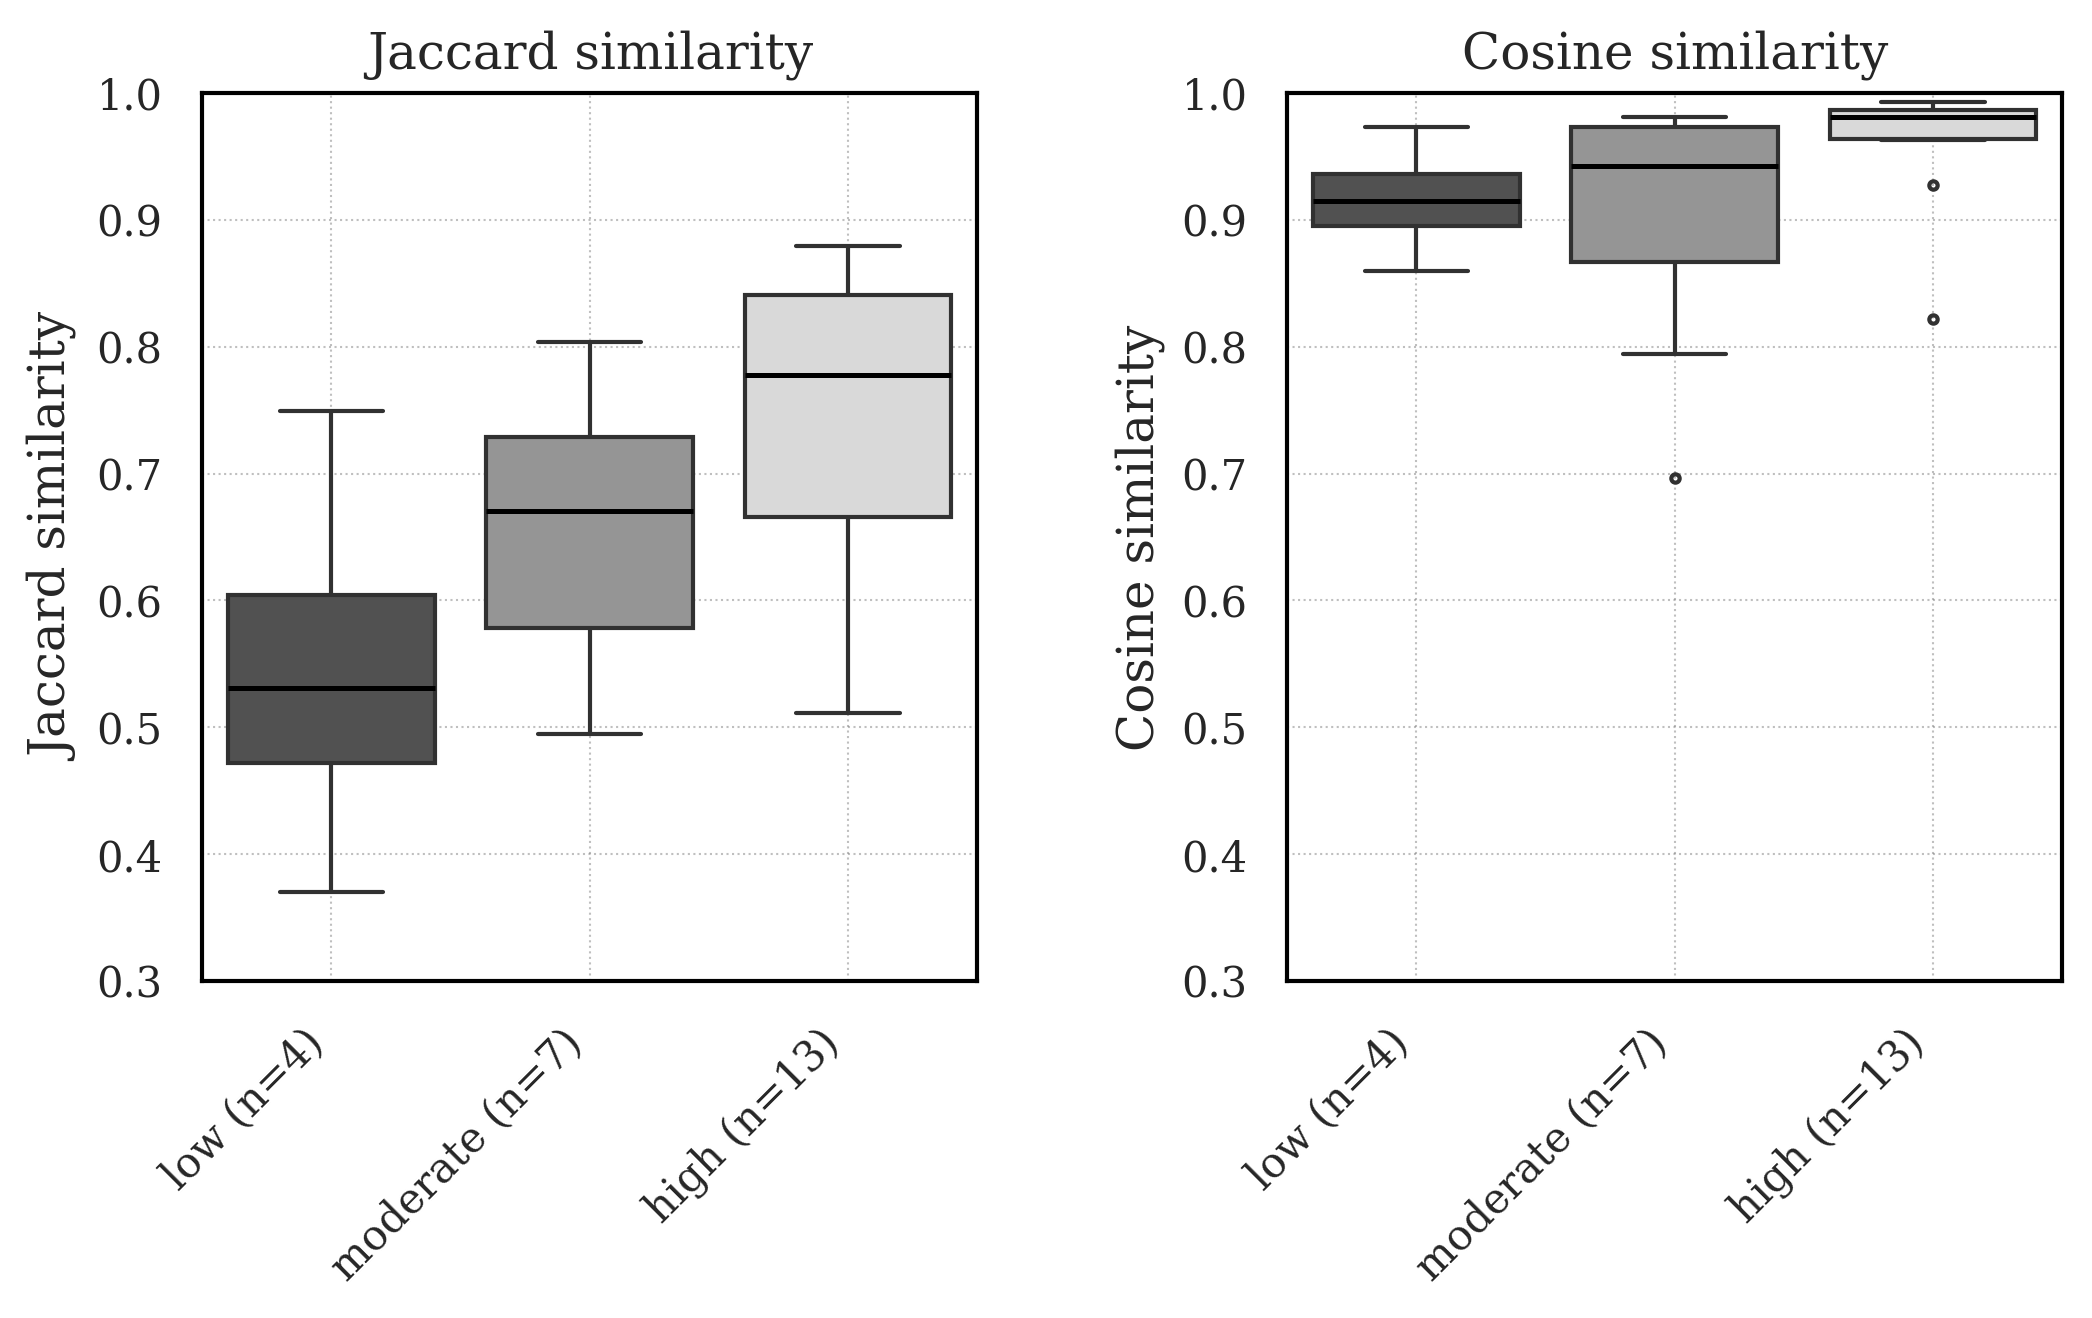

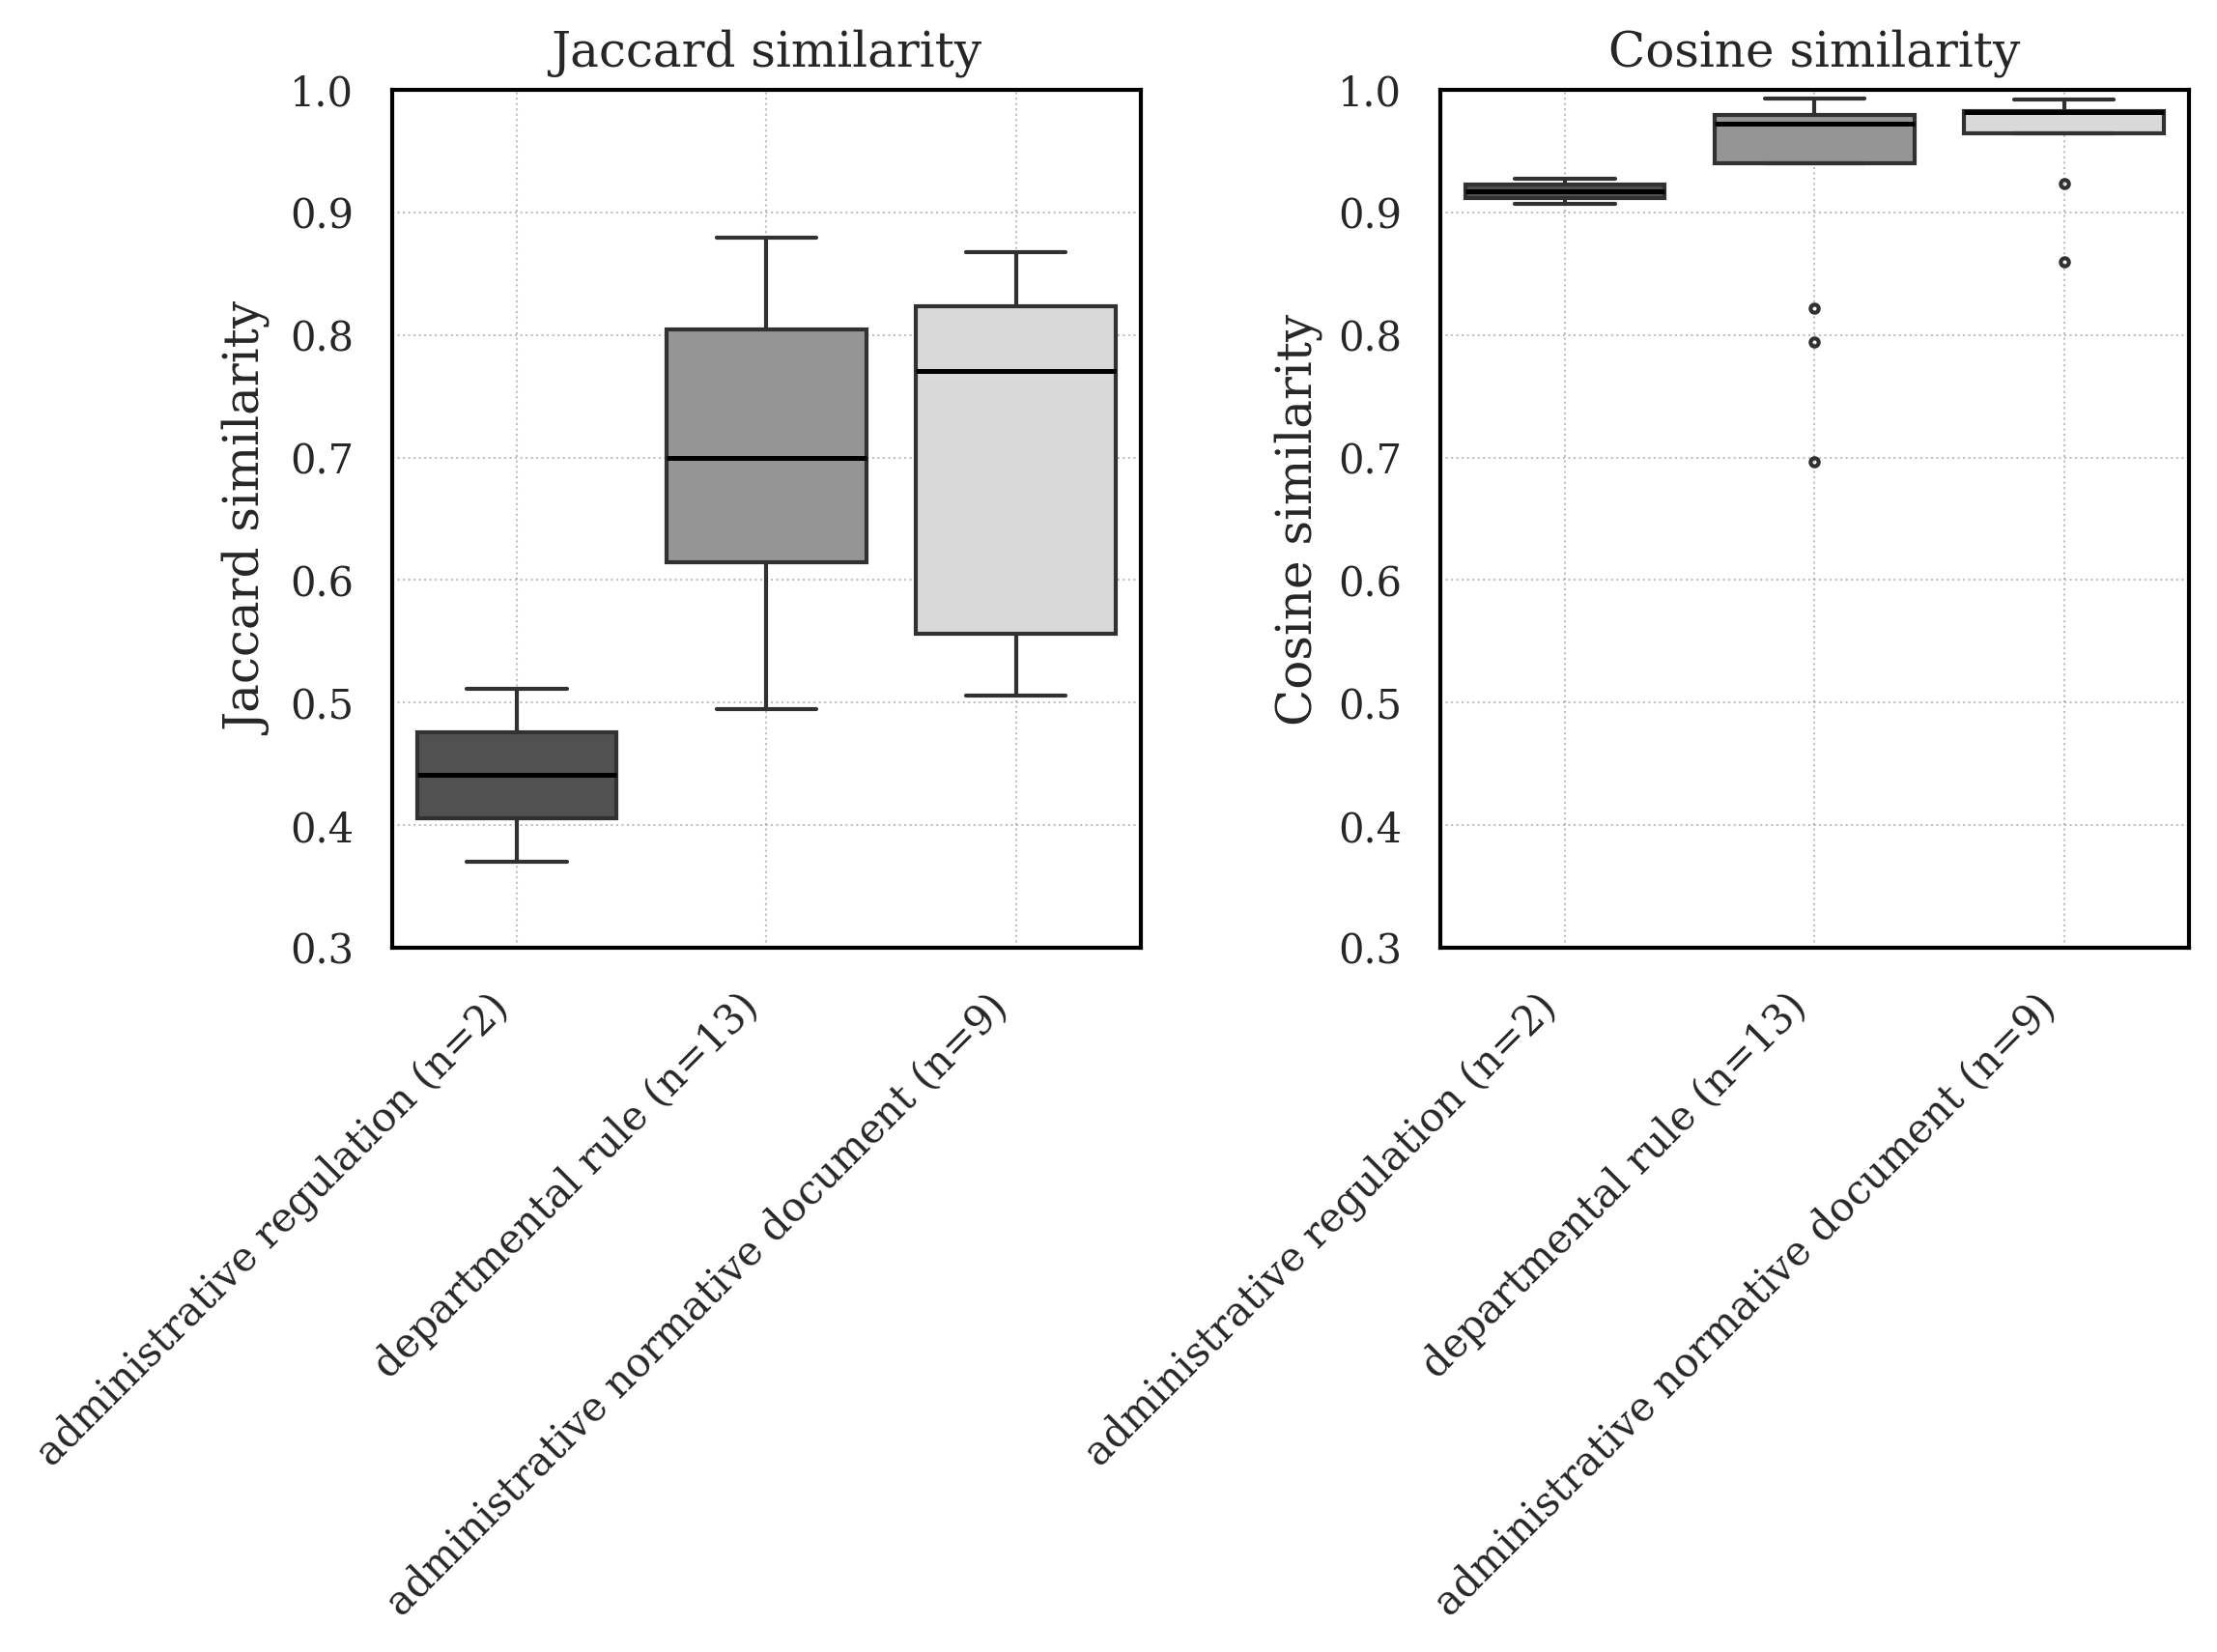

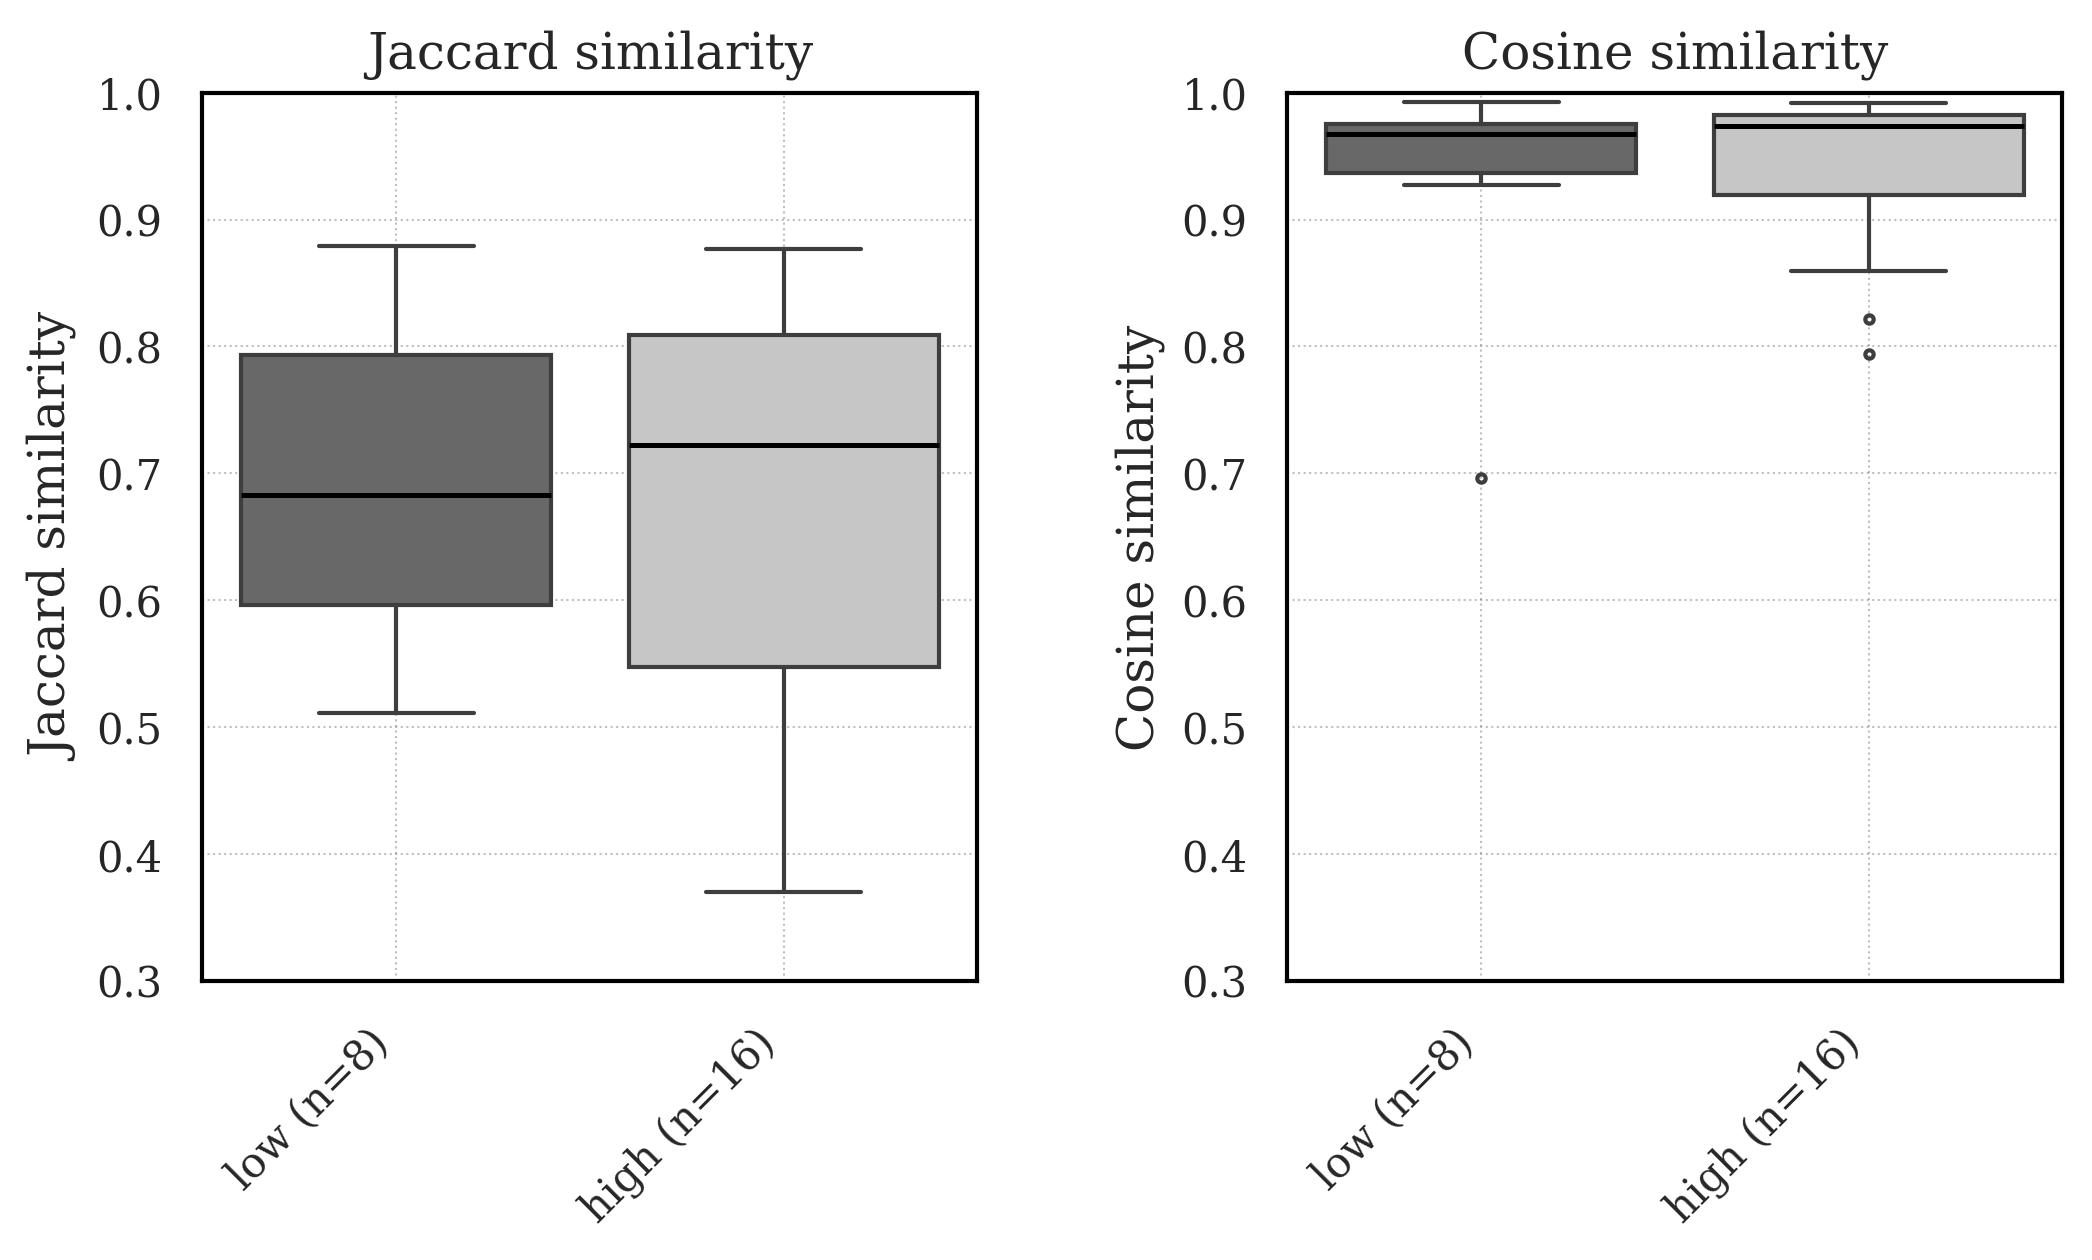

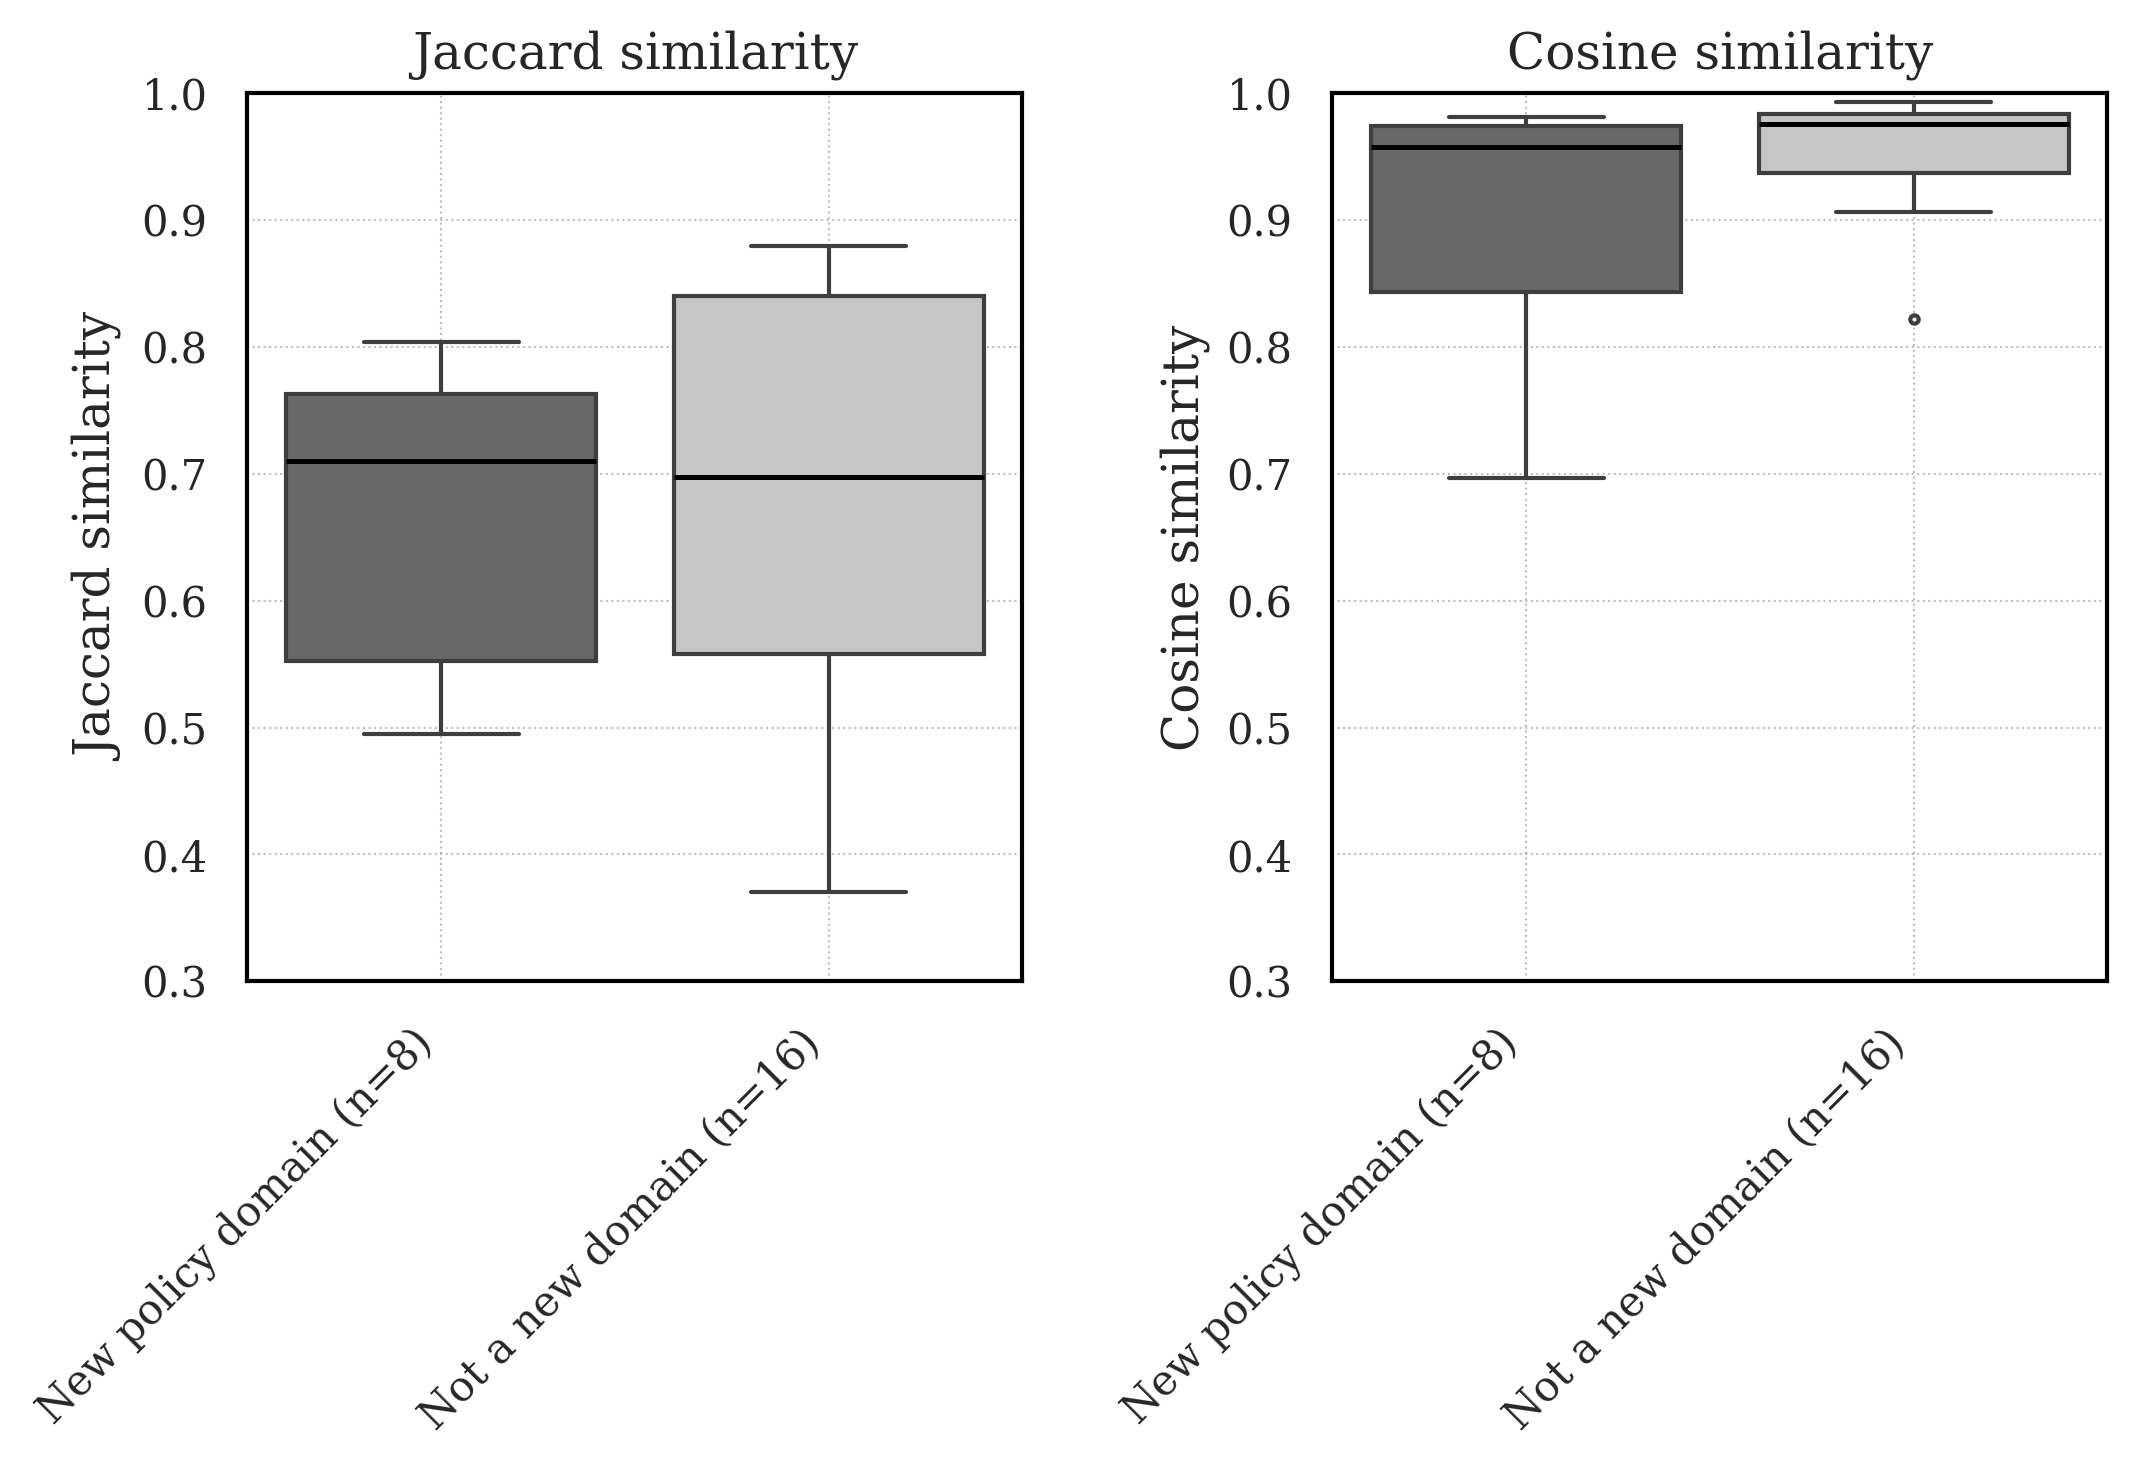

In [58]:
def sim_boxplot(x, df_comments, varss, labels, legend_labels=None, 
                bg_color="#ffffff", use_color=False):
    """
    Boxplots of similarity by categorical variable (publication-quality).

    Parameters
    ----------
    x : str
        Column name for categorical variable.
    df_comments : DataFrame
        Data containing similarity columns.
    varss : list
        Category keys to include (in desired order).
    labels : list
        Human-readable labels matching `varss`.
    legend_labels : list, optional
        Legend titles for similarity types.
    bg_color : str, optional
        Background color of the figure (default white).
    use_color : bool, optional
        If True, use distinct colors; otherwise grayscale-safe.
    """
    sim_types = ["jaccard_similarity", "cosine_similarity"]
    sim_labels = legend_labels or ["Jaccard similarity", "Cosine similarity"]

    # Select palette
    if use_color:
        palette = sns.color_palette("muted", n_colors=len(varss))
    else:
        palette = sns.color_palette("Greys", n_colors=len(varss))[::-1]

    fig, axes = plt.subplots(1, len(sim_types), figsize=(8, 4))
    plt.subplots_adjust(wspace=0.4, top=0.85)
    fig.patch.set_facecolor(bg_color)
    for ax in axes:
        ax.set_facecolor(bg_color)

    for count, sim in enumerate(sim_types):
        df = df_comments[[x, sim]]
        df = df[df[x].isin(varss)].reset_index(drop=True)
        df[x] = pd.Categorical(df[x], categories=varss, ordered=True)
        df = df.sort_values(x)

        # Compute counts per category
        n_counts = [len(df[df[x] == v]) for v in varss]
        new_labels = [f"{lab} (n={n})" for lab, n in zip(labels, n_counts)]

        ax = axes[count]
        sns.boxplot(
            x=x,
            y=sim,
            data=df,
            ax=ax,
            palette=palette,
            fliersize=2,
            linewidth=1,
            medianprops=dict(color='black', linewidth=1.2)
        )

        # Replace x-tick labels *after* plotting for perfect alignment
        ax.set_xticks(range(len(varss)))
        ax.set_xticklabels(new_labels, rotation=45, ha='right')

        ax.set_ylim([0.3, 1])
        ax.set_xlabel("")
        ax.set_ylabel(sim_labels[count])
        ax.set_title(sim_labels[count])
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend([], [], frameon=False)

    return fig
        
#matplotlib.rcParams['figure.figsize'] = [8, 4]
#sim_boxplot('comment_period_days', df_comments, varss=[14.0, 30.0], labels=["14 days", "30 days"])
#plt.savefig('Fig_10.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')


sim_boxplot('policy_preference', df_comments, varss=['low', 'mixed', 'high'], labels=['low', 'moderate', 'high'])
plt.savefig('Fig_3.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
#sim_boxplot('doc_type', df_comments, varss=['办法', '规定', '条例'], labels=['Measures', 'Provisions', 'Regulation'])
#plt.savefig('Fig_8.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')

sim_boxplot('regulation_type', df_comments, varss=['administrative regulation', 'departmental rule', 'administrative normative document'], 
            labels=['administrative regulation', 'departmental rule', 'administrative normative document'])
plt.savefig('Fig_7.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')


sim_boxplot('social_contention', df_comments, varss=['low', 'high'], labels=['low', 'high'])
plt.savefig('Fig_5.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')

sim_boxplot('new_policy_domain', df_comments, varss=['x', 'n'], labels=['New policy domain', 'Not a new domain'])
plt.savefig('Fig_8.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')




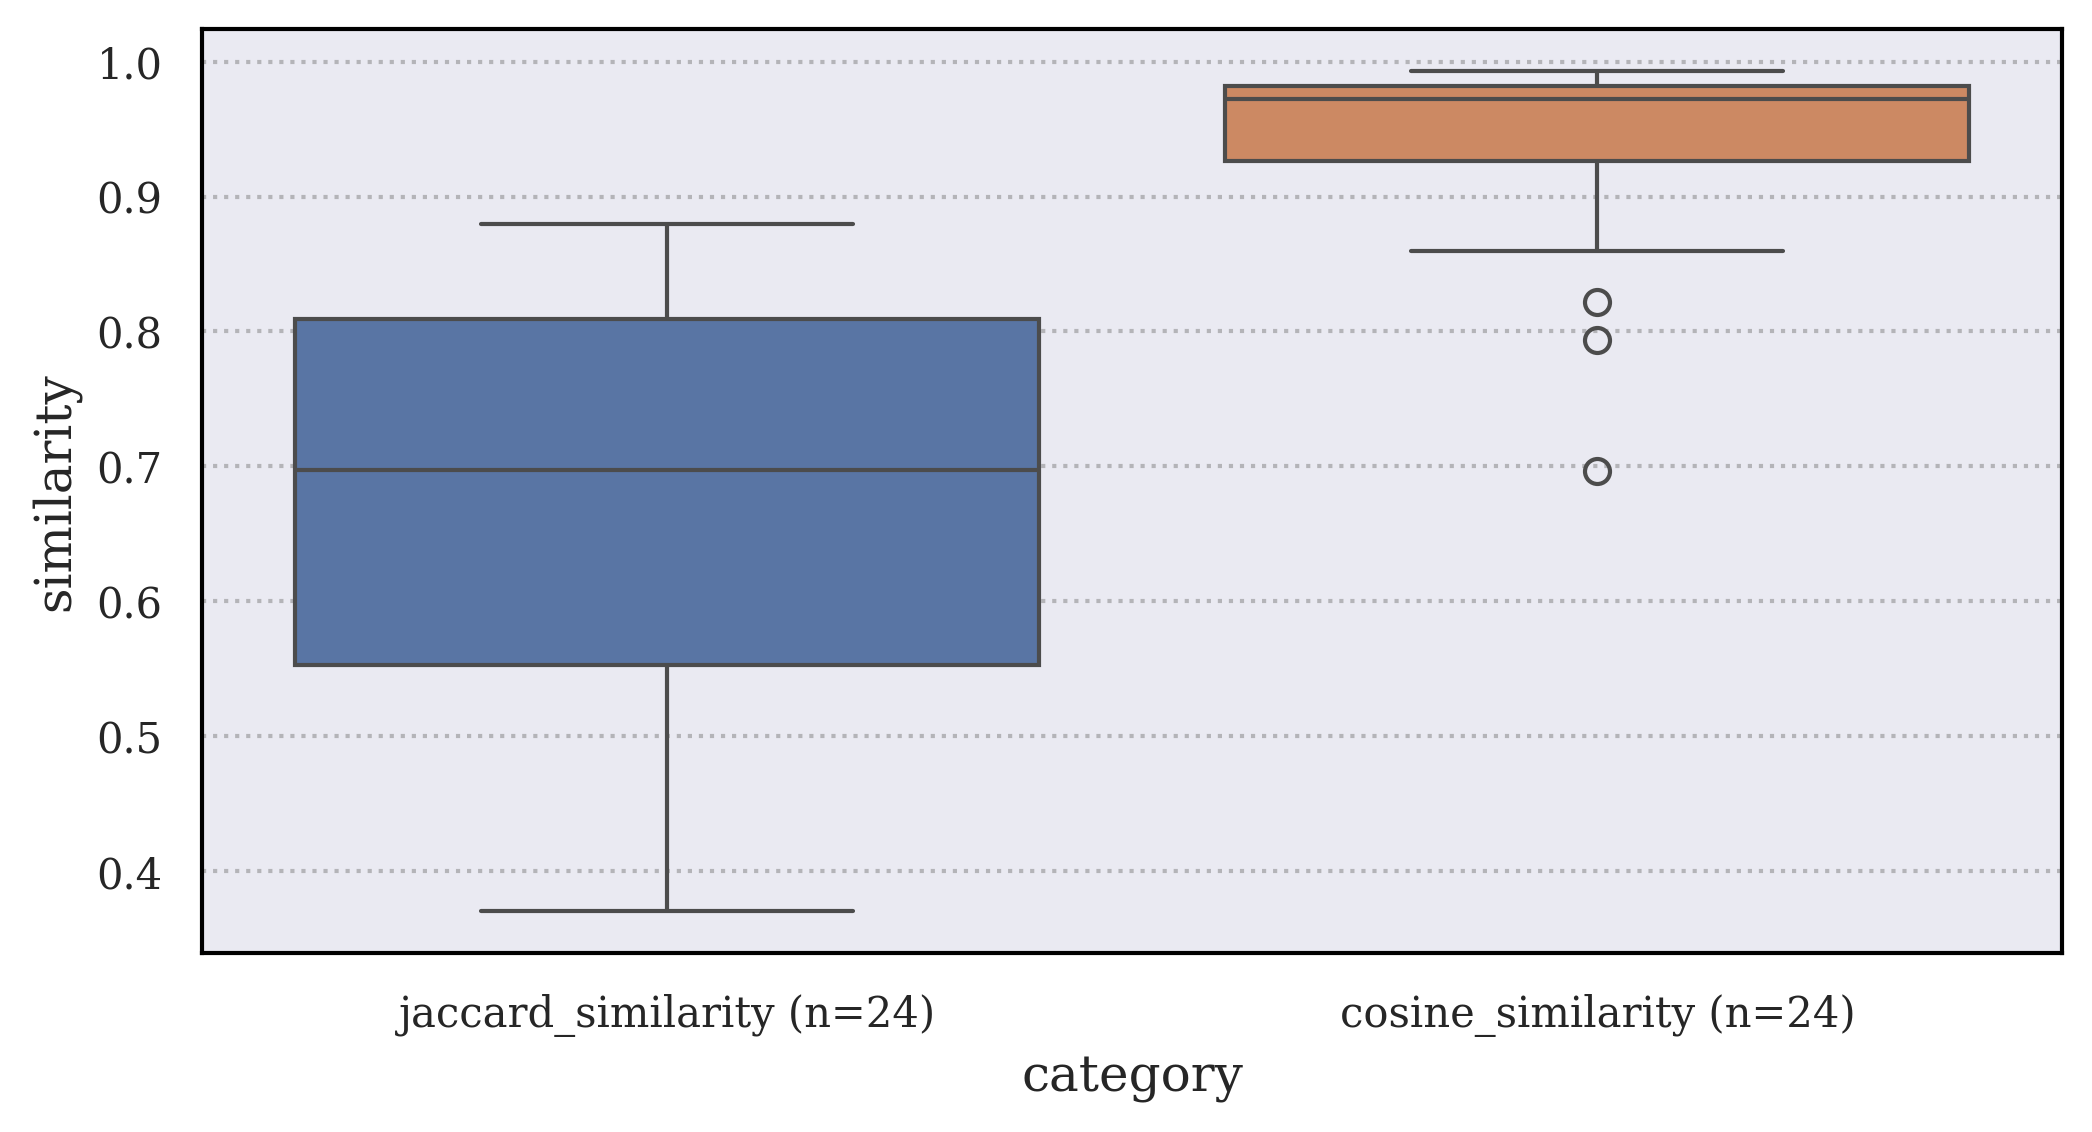

In [59]:
def boxplot(x, y, df_comments, varss, labels):
    df = df_comments[[x, y]]
        
    if x == "comment_period_days":
        """
        NOTE: variables with notice period of 21 days are removed here due to low n=2
        """
        df = df[df["comment_period_days"] != 21.0].reset_index(drop=True)

    df[x] = df[x].astype('category')
    df[x] = df[x].cat.set_categories(varss)
    df = df.sort_values(x)
    #print(df)
    
    fig, ax = plt.subplots()
    def replace_labels(df, varrs, labels):
        for i in range(len(varrs)):
            var = varrs[i]
            label = labels[i]
            ln = int(len(df.loc[df[x] == var]))

            df[x] = [f"{label} (n={str(ln)})" if x == var else x for x in df[x]]
        return df

    df = replace_labels(df, varss, labels)
    
    
    sns.boxplot(x=df[x], y=df[y], hue=df[x], ax=ax)
    plt.legend([],[], frameon=False)
#boxplot('sensitivity', "time_to_pub", df_comments, varss=['low', 'mixed', 'high'], labels=['low', 'mixed', 'high'])



sim = []
cat = []
for i in range(len(df_comments)):
    sim.append(df_comments["jaccard_similarity"][i])
    cat.append("jaccard_similarity")
    sim.append(df_comments["cosine_similarity"][i])
    cat.append("cosine_similarity")

matplotlib.rcParams['figure.figsize'] = [8, 4]
sim_df = pd.DataFrame({"category": cat, "similarity": sim})
#print(sim_df)
boxplot("category", "similarity", sim_df, varss=['jaccard_similarity', 'cosine_similarity'], labels=['jaccard_similarity', 'cosine_similarity'])
plt.savefig('Fig_4.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')



['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


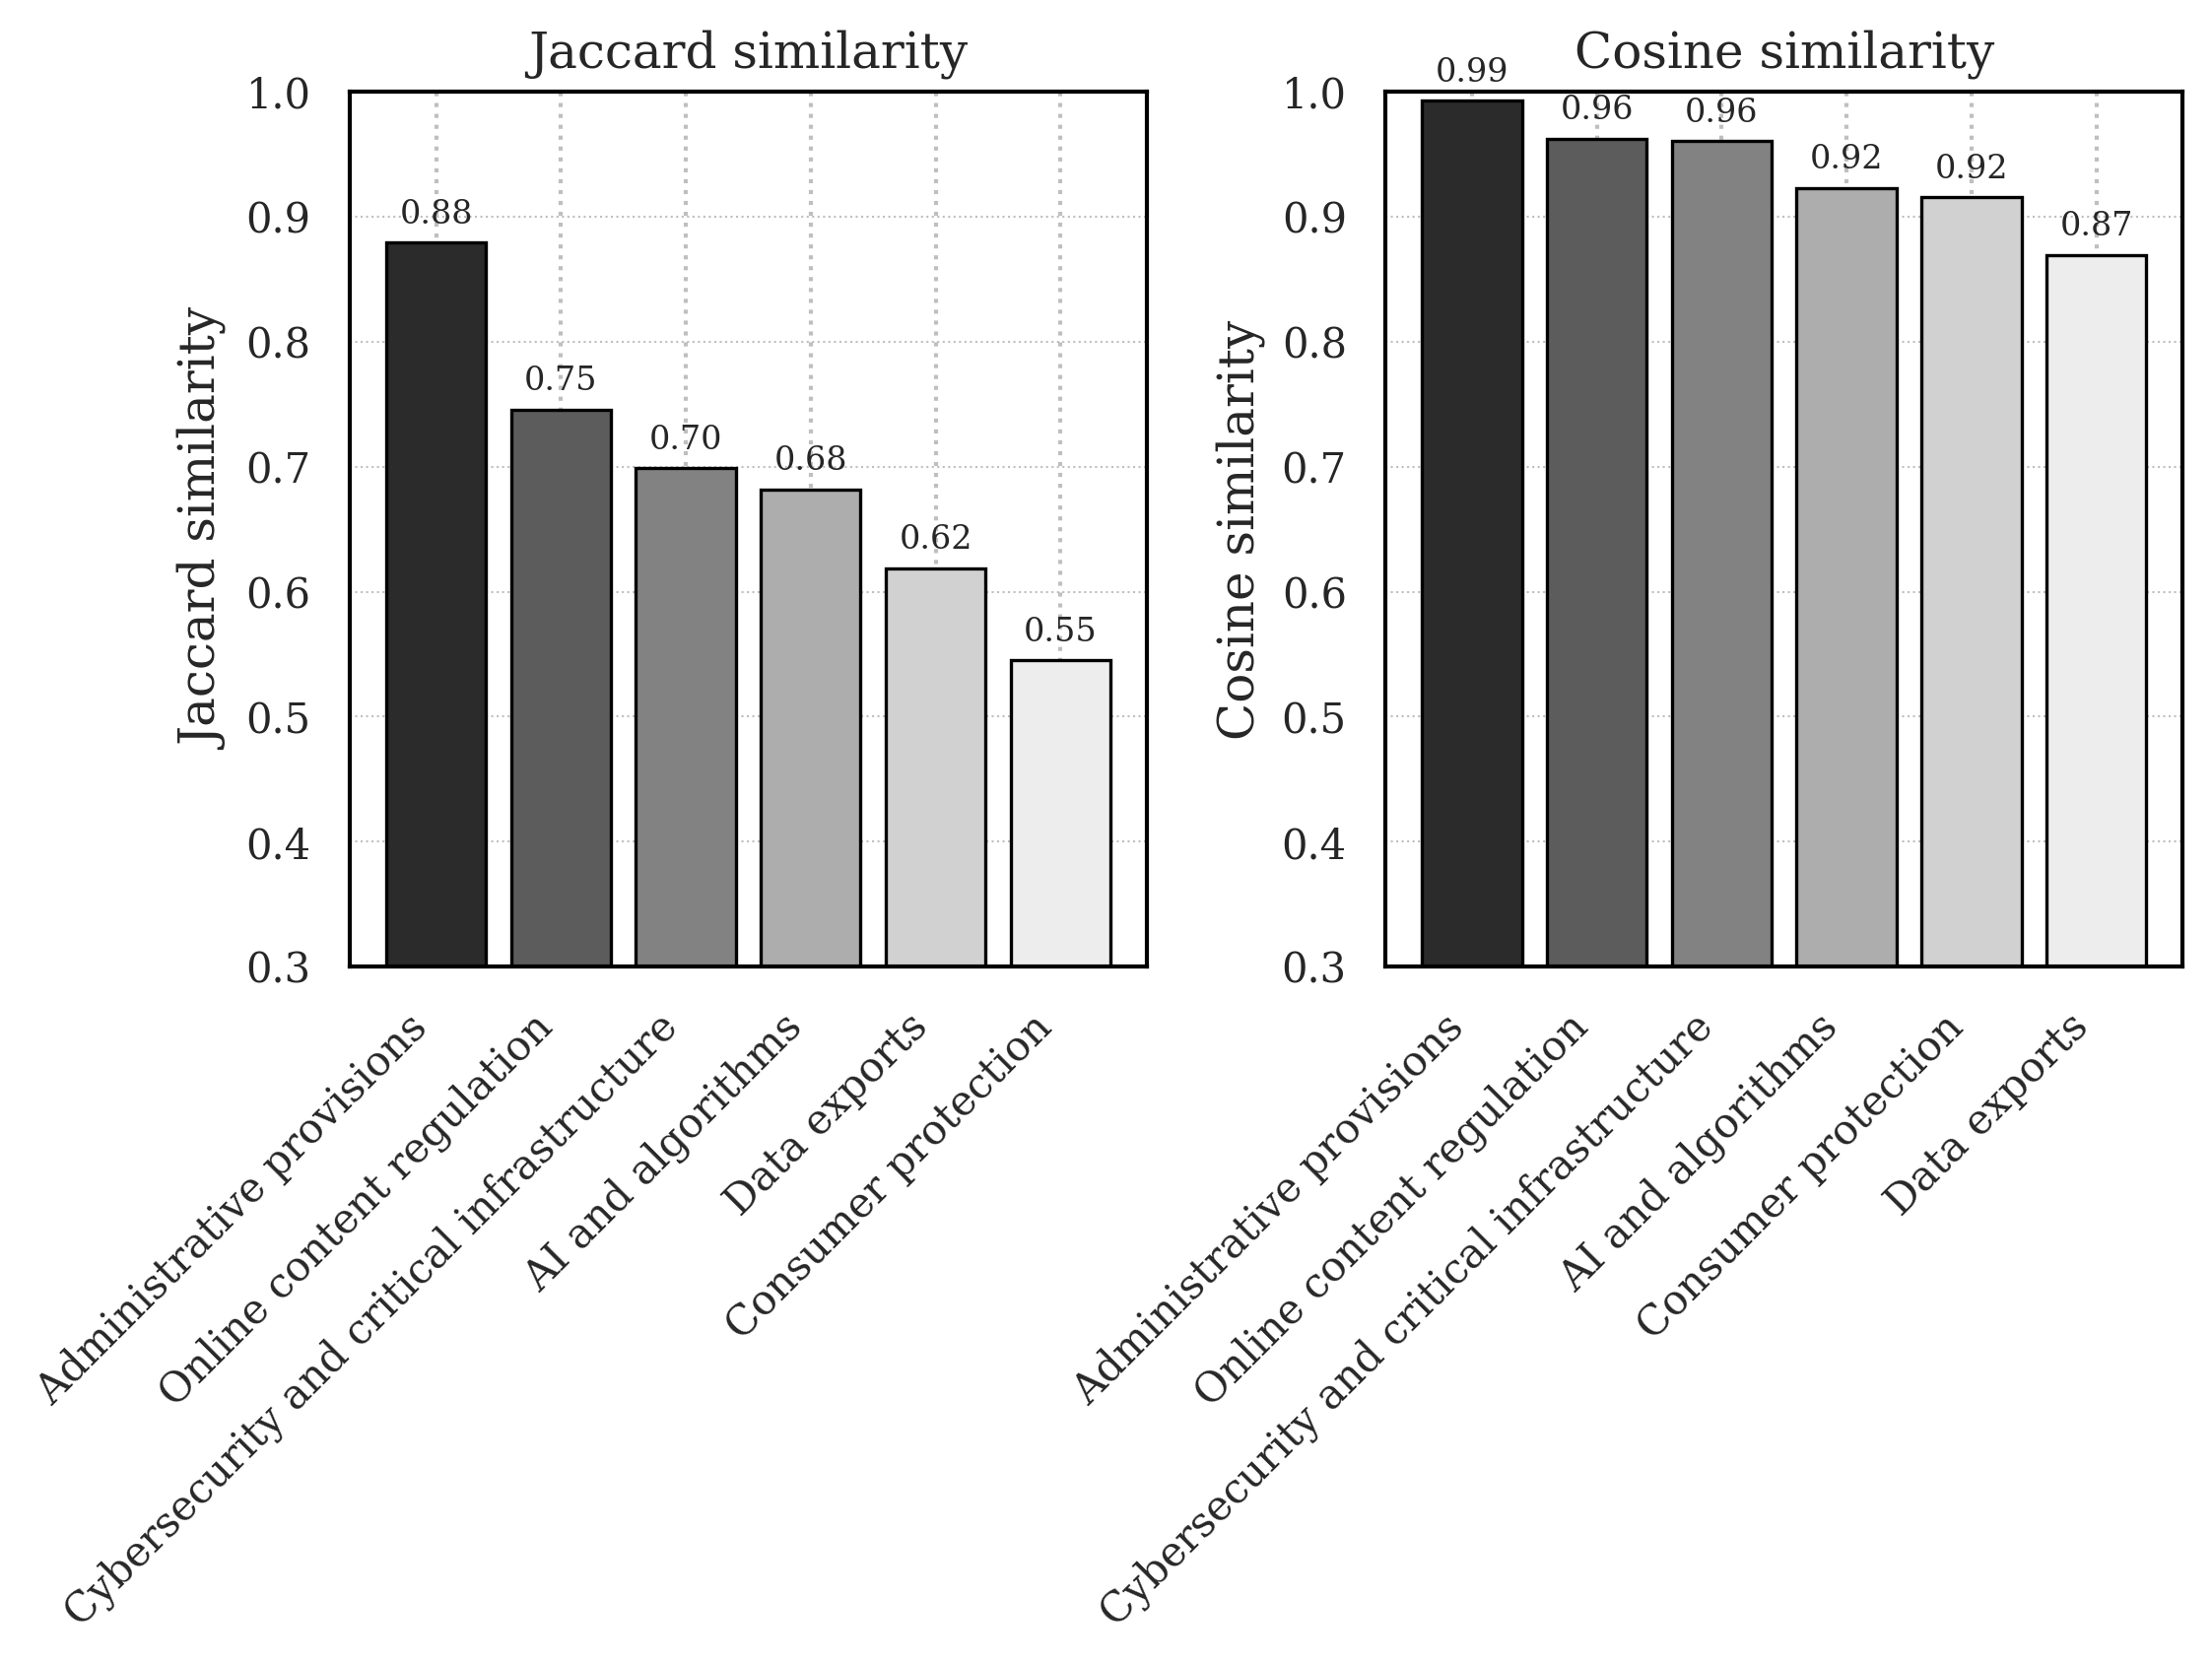

In [60]:
def calculate_percentage_public_year(df, legend_labels=None, bg_color="#ffffff", use_color=False):
    """
    Plots number of published documents per year by status (stacked bar, publication quality).

    Parameters
    ----------
    df : DataFrame
        Dataset with columns ['status', 'data_category', 'pub_date'].
    legend_labels : list, optional
        Custom legend labels for document statuses.
    bg_color : str, optional
        Background color of figure and axes (default: white).
    use_color : bool, optional
        If True, use muted color palette; otherwise grayscale-safe.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np

    # --- Data preparation ---
    df = df.loc[df['status'] != 'draft without final'].reset_index(drop=True)
    df = df.loc[df['data_category'] == 'reg'].reset_index(drop=True)
    df['year'] = df["pub_date"].astype(str).str[:4]
    df = df.groupby(by='year')['status'].value_counts().unstack()
    df.index = df.index.astype(int)
    df = df.reindex(range(2014, 2024))  # ensure full year range

    # --- Color palette setup ---
    if use_color:
        # muted color palette for color figures
        palette = sns.color_palette("muted", n_colors=len(df.columns))
    else:
        # grayscale shades for B&W printing
        palette = sns.color_palette("Greys", n_colors=len(df.columns))[::-1]

    # --- Create plot ---
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.patch.set_facecolor(bg_color)
    ax.set_facecolor(bg_color)

    # Convert index to numeric positions for tick alignment
    x_pos = np.arange(len(df.index))

    # Plot each stacked component manually for precise control
    bottom_vals = np.zeros(len(df))
    for i, col in enumerate(df.columns):
        ax.bar(
            x_pos,
            df[col].fillna(0),
            bottom=bottom_vals,
            color=palette[i],
            edgecolor="black",
            linewidth=0.8,
            label=col
        )
        bottom_vals += df[col].fillna(0).values

    # --- Formatting ---
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df.index.astype(str), rotation=45, ha="right")

    ax.set_ylabel("Number of published documents")
    ax.set_xlabel("Year of final publication")
    ax.set_title("Publication status by year")

    ax.grid(True, linestyle=":", linewidth=0.5, axis="y")

    # --- Legend ---
    if legend_labels:
        ax.legend(legend_labels, frameon=False, loc="upper left")
    else:
        ax.legend(frameon=False, loc="upper left")

    plt.tight_layout()
    return fig
    
# 1️⃣ Grayscale-safe version for academic paper
sim_bar_graph(df_comments, "topic", use_color=False)
print(sns.color_palette().as_hex())
plt.savefig('Fig_4.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
matplotlib.rcParams['figure.figsize'] = [4, 8]


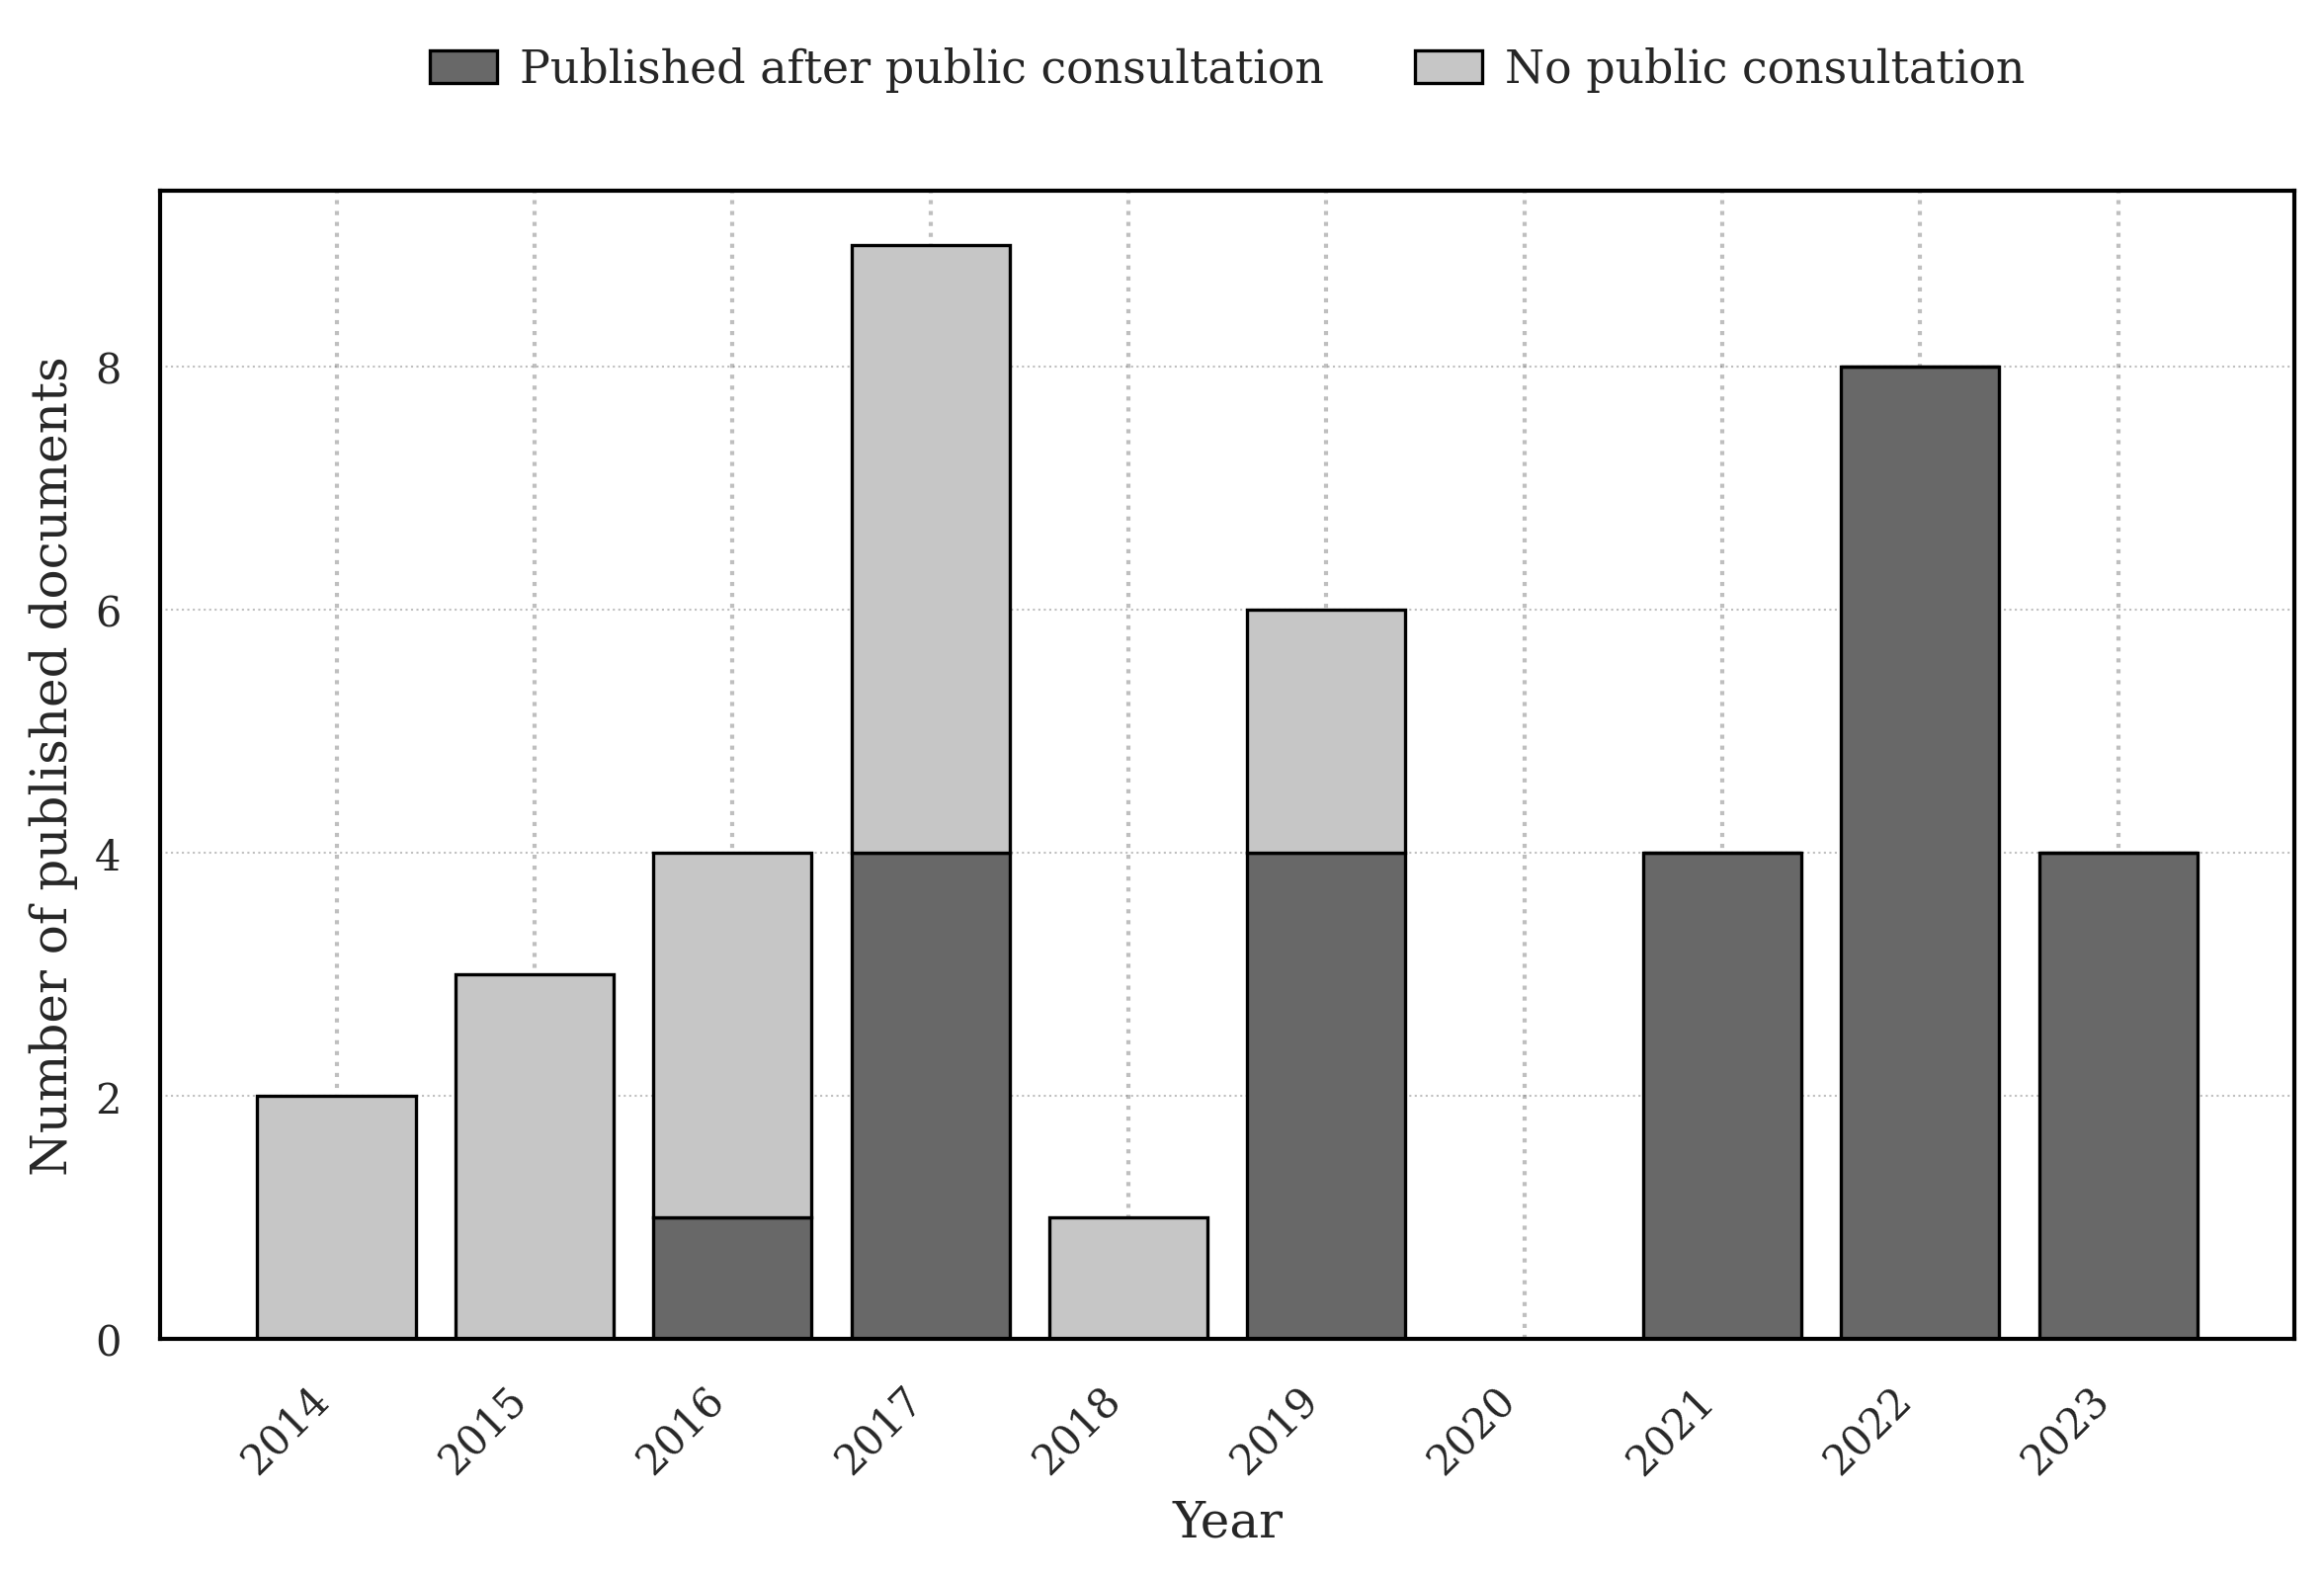

In [61]:
def calculate_percentage_public_year(df):
    df = df.loc[df['status'] != 'draft without final'].reset_index(drop=True)
    df = df.loc[df['data_category'] == 'reg'].reset_index(drop=True)
    df['year'] = df["pub_date"].astype(str).str[0:4]
    df = df.groupby(by='year')['status'].value_counts().unstack()
    print(df)
    #df.drop(df.tail(1).index,inplace=True)
    df.index = df.index.astype(int)

    df = df.reindex(range(2014, 2024))
    ax = df.plot.bar(stacked=True, figsize=(8,6))
    ax.set_ylabel("Number of published documents")
    
calculate_percentage_public_year(df)
matplotlib.rcParams['figure.figsize'] = [9, 5]
plt.savefig('Fig_1.tiff', dpi=1200, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')



14 days     9
21 days     2
30 days    22
Name: count, dtype: int64


C:\Users\vbrus\AppData\Local\Temp\ipykernel_9036\95117157.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.plot.pie(autopct=make_autopct(df[[0]]), figsize=(6,6))


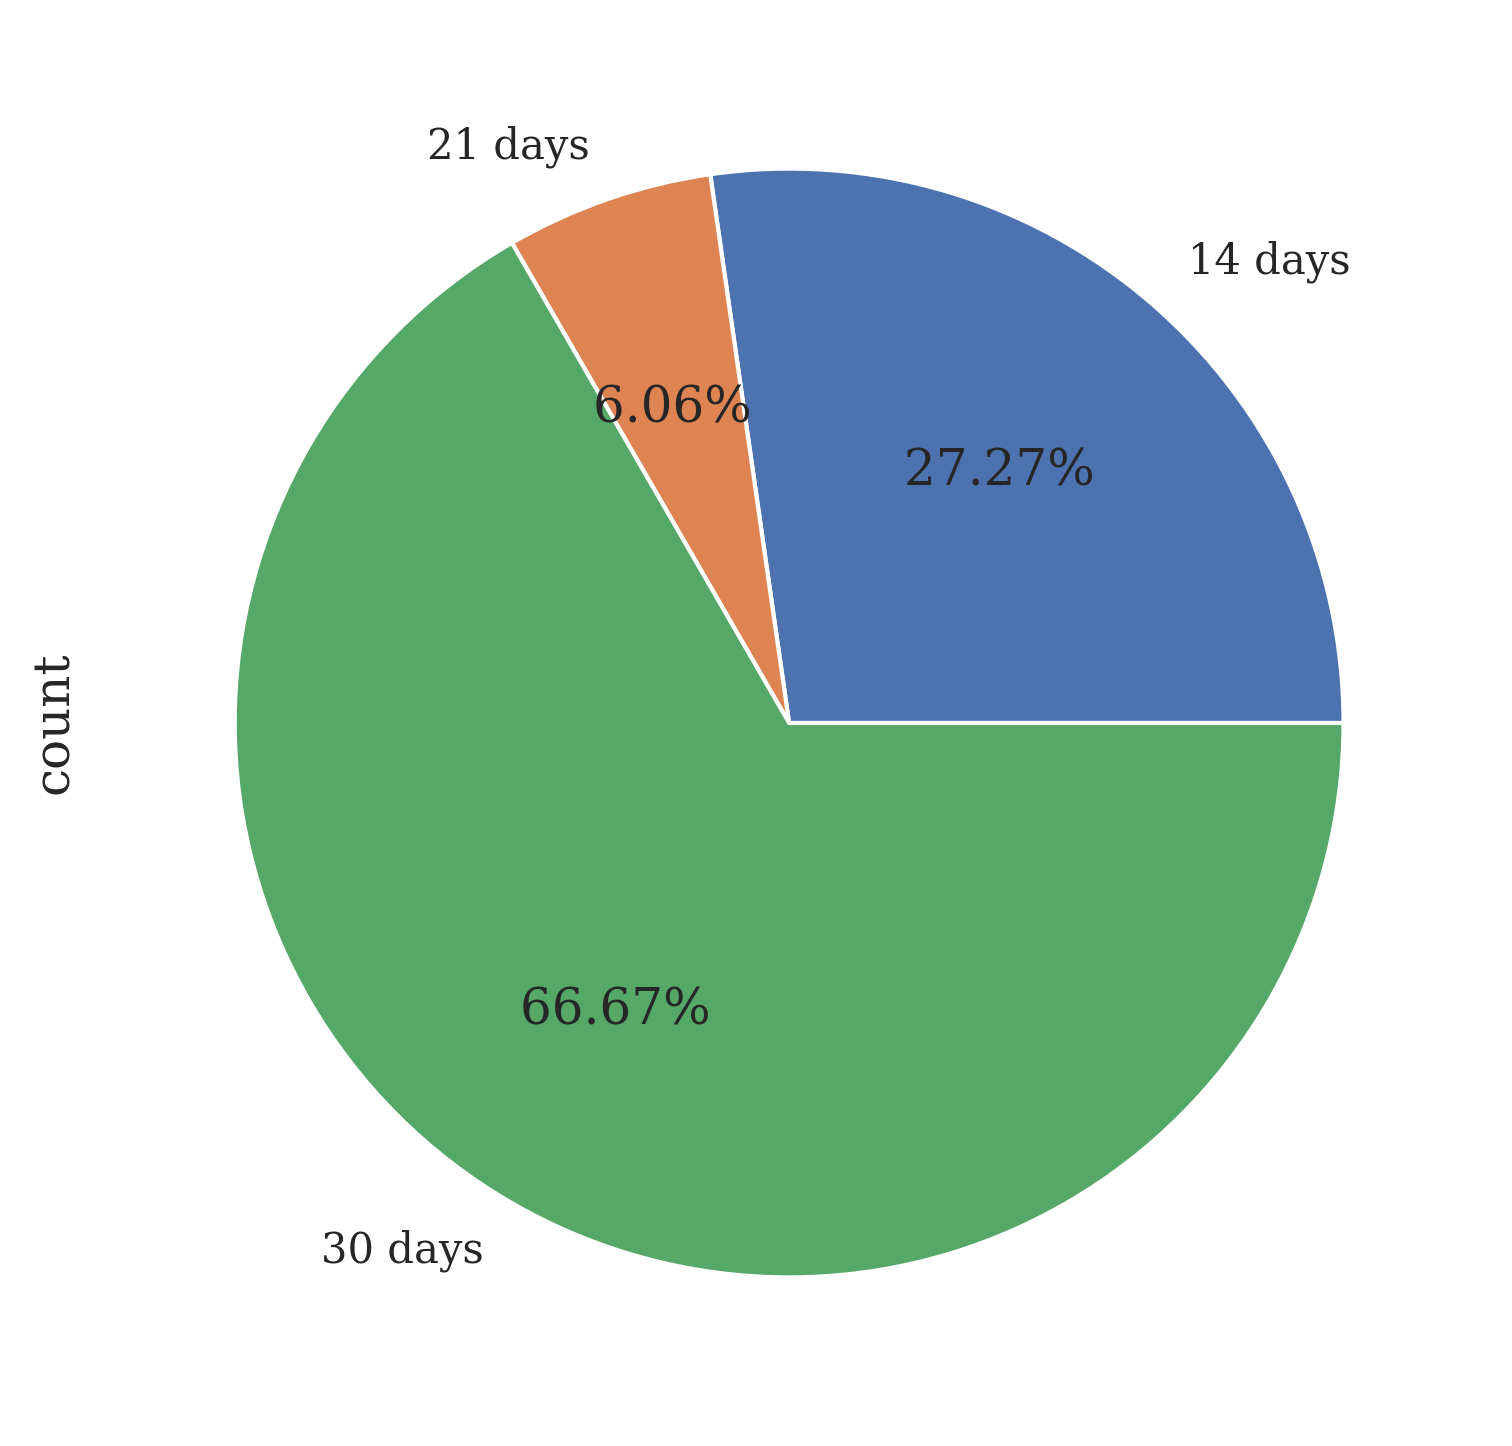

In [62]:
def get_pie_chart(df):
    df = df[['comment_period_days']].groupby('comment_period_days').value_counts()
    df.index = ['14 days', '21 days', '30 days']
    print(df)
    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}% '.format(p=pct,v=val)
        return my_autopct
    df.plot.pie(autopct=make_autopct(df[[0]]), figsize=(6,6))
    
get_pie_chart(df)